In [91]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pickle

def sign_val(a):
    if(a>1e-4):
        return 1
    elif(a<-1e-4):
        return -1
    else:
        return 0
def coth(x):
    return 1 / math.tanh(x)
plank_constant = 1
tau = 15
omega_1 = 0.1
omega_2 = 0.5
beta_1 = 1.0
beta_2 = 0.75
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_learning_rate = 0.01
adam_epsilon = 1e-8
constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)

def reLU(val):
  return np.maximum(0, val)
def reLU_derivative(z):
    if(z>0):
        return 1
    if(z<0):
        return 0
    if(z==0):
        print("z = 0 , NN is giving same value at both zero and tau ")
def simpsons_3_8_rule_integration(func, a = 0, b = 0, n=999):
    h = (b - a) / n
    integral_sum = func(a) + func(b)  
    
    for i in range(1, n):
        x_i = a + i * h
        if i % 3 == 0:
            integral_sum += 2 * func(x_i)  
        else:
            integral_sum += 3 * func(x_i) 
    
    integral_approximation = (3 * h / 8) * integral_sum
    return integral_approximation


def function_derivative_integrand(val,val_1,val_2,val_theta,val_1_theta,val_2_theta):
    val = torch.ones_like(val_theta) * val
    val_1 = torch.ones_like(val_theta) * val_1
    val_2 = torch.ones_like(val_theta) * val_2
    sign_integrand = (-0.75)*(val_1**2)/(val**2) + (0.5)*(val_2/val)
    sign = torch.where(sign_integrand > 0, torch.tensor(1), torch.tensor(-1))
    
    return ((-0.75) * ((2 * val_1 * (val ** (-3)) * val_1_theta) + (-3) * (val_1 ** 2) * ((val ** (-4)) * val_theta)) +
          (0.5) * (((val ** (-2)) * val_2_theta) + ((-2) * (val ** (-3)) * val_theta * val_2)))*sign
def Cab_derivative_wrt_param(integral_part_derivative_wrt_param):
    return constant_part*integral_part_derivative_wrt_param



class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # Define the layers
        
        self.input_layer = nn.Linear(1, 10)
        self.poly_layer = nn.Linear(10, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.poly_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0] 
        gradients_first_derivative = []
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
    def gradients_wrt_time(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0]
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        return output,grad_output,grad_grad_output
    def C_AB(self,):
        Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b = tau)
        return constant_part*Integral_part
    def cost_function(self,P):
        output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
        output_time0,grad_output_time0,grad_grad_output_time0 = output_time0.item(),grad_output_time0.item(),grad_grad_output_time0.item()
        output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
        output_timetau,grad_output_timetau,grad_grad_output_timetau = output_timetau.item(),grad_output_timetau.item(),grad_grad_output_timetau.item()
        # return self.C_AB() + P[0]*(abs(output_time0 - omega_1)) +\
        #                   P[1]*(abs(grad_output_time0)) +\
        #                   P[2]*(abs(grad_grad_output_time0)) +\
        #                   P[3]*(abs(output_timetau - omega_2)) +\
        #                   P[4]*(abs(grad_output_timetau)) +\
        #                   P[5]*(abs(grad_grad_output_timetau)) +\
        #                   P[6]*reLU(output_time0-output_timetau)    
        return  P[3]*(abs(output_timetau - omega_2)) + P[0]*(abs(output_time0 - omega_1))
        # return self.C_AB()
    def Integrand_function(self,t,sign=False):
        val , val_1 , val_2 = self.gradients_wrt_time(t)   
        val , val_1 , val_2 = val.item() , val_1.item() , val_2.item()
   
        return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 


P_val = np.array([
    [1, 1, 1, 0.1, 1, 1, 16],
    [2, 2, 2, 2, 2, 2, 16],
    [4, 4, 4, 4, 4, 4, 16],
    [8, 8, 8, 8, 8, 8, 16]
])
cost_fun = []
param_step = []
bar = progressbar.ProgressBar(maxval=1000, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for initial_conditions in range(5):
    bar.update(initial_conditions+1)
    net = CustomNet()
    parameters = list(net.parameters())
    loss_func_param_gradient = [torch.zeros_like(param) for param in parameters]
    cost_fun.append([])

    for pass_idx in range(1):
        m_curr = [torch.zeros_like(param) for param in parameters]
        v_curr = [torch.zeros_like(param) for param in parameters]
        m_prev = [torch.zeros_like(param) for param in parameters]
        v_prev = [torch.zeros_like(param) for param in parameters]
        t = 0
        P = P_val[pass_idx]
        # for i in range (len(m)):
        #     print(m_curr[i].shape)
        for step in range(250):
            t = t + 1
            n=99
            h = tau/n
            a = 0
            b = tau
            gradients_zeroth_derivative_a, gradients_first_derivative_a , gradients_second_derivative_a , output_a , grad_output_a , grad_grad_output_a = net.calculate_gradients_param(a)
            gradients_zeroth_derivative_b, gradients_first_derivative_b , gradients_second_derivative_b , output_b , grad_output_b , grad_grad_output_b  = net.calculate_gradients_param(b)
            
            # for i in range(len(loss_func_param_gradient)):
                
            #     loss_func_param_gradient[i] = function_derivative_integrand(output_a.item(),grad_output_a.item(),grad_grad_output_a.item(),gradients_zeroth_derivative_a[i],gradients_first_derivative_a[i],gradients_second_derivative_a[i]) + \
            #     function_derivative_integrand(output_b.item(),grad_output_b.item(),grad_grad_output_b.item(),gradients_zeroth_derivative_b[i],gradients_first_derivative_b[i],gradients_second_derivative_b[i])
            # for integration_step in range(n):
            #     x_i = a + integration_step * h
            #     gradients_zeroth_derivative, gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output = net.calculate_gradients_param(x_i)
            #     for i in range(len(loss_func_param_gradient)):    
            #         if (integration_step+1) % 3 == 0:
            #             loss_func_param_gradient[i] = loss_func_param_gradient[i] + 2*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
            #         else:
            #             loss_func_param_gradient[i] = loss_func_param_gradient[i] + 3*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
            
            # for j in range(len(loss_func_param_gradient)):    
            #     loss_func_param_gradient[j] = (3 * h / 8) * loss_func_param_gradient[j]  
            
            
            for j in range(len(loss_func_param_gradient)):  
                term_1 = sign_val(output_a.item()-omega_1)*P[0]*(gradients_zeroth_derivative_a[j])
                # term_2 = sign_val(grad_output_a.item())*P[1]*(gradients_first_derivative_a[j])
                # term_3 = sign_val(grad_grad_output_a.item())*P[2]*(gradients_second_derivative_a[j])
                term_4 = sign_val(output_b.item()-omega_2)*P[3]*(gradients_zeroth_derivative_b[j])
                
                # term_5 = sign_val(grad_output_b.item())*P[4]*(gradients_first_derivative_b[j])
                # term_6 = sign_val(grad_grad_output_b.item())*P[5]*(gradients_second_derivative_b[j])
                # term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])*reLU_derivative(output_a.item()-output_b.item())
                # if(reLU_derivative(output_a.item()-output_b.item())):
                #     term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                # else:
                #     term_7 = 0*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                loss_func_param_gradient[j] =      term_4 + term_1



            for i in range(len(loss_func_param_gradient)):   

                # m_curr[i] = (adam_beta_1 * m_prev[i] + (1 - adam_beta_1) * loss_func_param_gradient[i] )
                # v_curr[i] = (adam_beta_2 * v_prev[i] + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                
                # m_hat = m_curr[i] / (1 - adam_beta_1**t)
                # v_hat = v_curr[i] / (1 - adam_beta_2**t)
                # m_prev[i] = m_curr[i]
                # v_prev[i] = v_curr[i]
                
                # m_curr[i] = ((adam_beta_1 * m_prev[i])- (1 - adam_beta_1) * loss_func_param_gradient[i] )
                # v_curr[i] = ((adam_beta_2 * v_prev[i]) + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                # delta_w = (-adam_learning_rate)*m_curr[i]*loss_func_param_gradient[i] / (torch.sqrt(v_curr[i]) + adam_epsilon)
                # print(v_curr[i])

                # parameters[i] = parameters[i] - delta_w
                # parameters[i] = parameters[i] - (adam_learning_rate * m_hat / (torch.sqrt(v_hat) + adam_epsilon))
                parameters[i] = parameters[i] - (adam_learning_rate)*loss_func_param_gradient[i]
            i = 0    
            
            k = 0
            # for param in net.parameters():
            #     # print()   
            #     # print() 
            #     if(param.shape!=parameters[k].shape):
            #         print(param.shape , " and " , parameters[k].shape , step , k)
            #     k = k + 1

            a = 0
            for param in net.parameters():
                
                # if(a==0):
                #     a = 1
                # print(param.data)
                param.data = parameters[i]
                i = i + 1
            cost_fun[initial_conditions].append(net.cost_function(P_val[0]))
    param_step.append(parameters)

with open('parrot.pkl', 'wb') as f:
    pickle.dump(cost_fun, f)

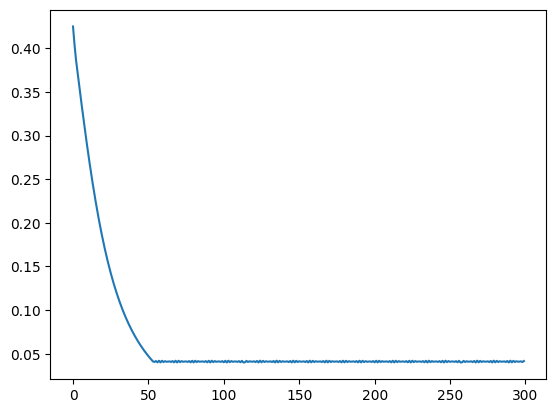

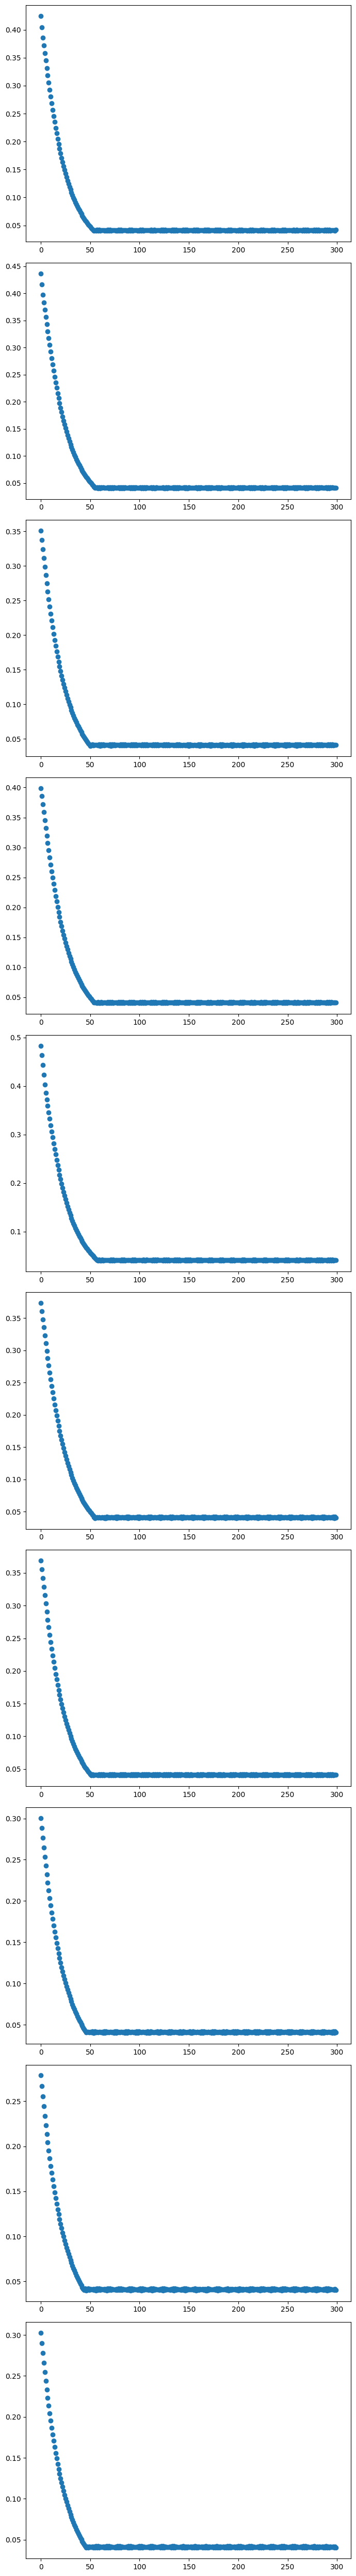

In [92]:
import pickle

# Specify the file name for the pickle file
file_name = "parrot.pkl"

# Open the file in binary read mode
with open(file_name, "rb") as file:
    loaded_list = pickle.load(file)

# Print the loaded list
import matplotlib.pyplot as plt
steps = [i for i in range(300)]
plt.plot(steps,loaded_list[0])
fig, axes = plt.subplots(5, 1, figsize=(7, 50))
for i in range(10):
    axes[i].scatter(steps, loaded_list[i])
    
plt.tight_layout()
plt.show()

In [66]:
import numpy as np
import matplotlib.pyplot as plt
omega = []
time = np.arange(0, 15, 0.01)


for t in time:
    input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
    omega.append(net.forward(input_data).item())
    

In [93]:
input_data0 = torch.tensor([[0]], dtype=torch.float32, requires_grad=True)
input_datatau = torch.tensor([[15]], dtype=torch.float32, requires_grad=True)

for step in range(10):
    i = 0
    for param in net.parameters():
                
        # if(a==0):
        #     a = 1
        # print(param.data)
        param.data = param_step[step][i]
        i+=1
    print(net.forward(input_data0).item() , net.forward(input_datatau).item())

0.10193400830030441 0.10193400830030441
0.09941720217466354 0.09941720217466354
0.09900526702404022 0.09900526702404022
0.10170836001634598 0.10170836001634598
0.09905306994915009 0.09905306994915009
0.10050656646490097 0.10050656646490097
0.09898978471755981 0.09898978471755981
0.1005728617310524 0.1005728617310524
0.09973860532045364 0.09973860532045364
0.09986943751573563 0.09986943751573563


In [54]:
type(parameters[0])

torch.Tensor

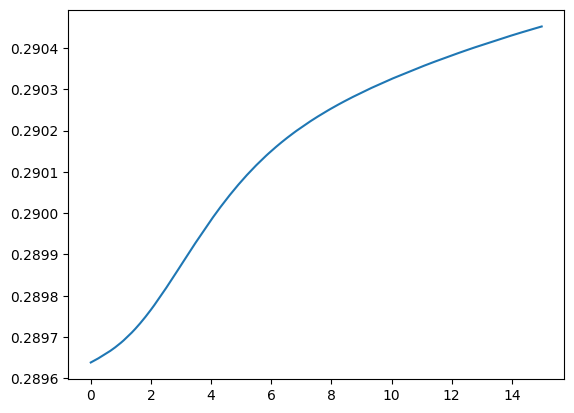

In [39]:
plt.plot(time,omega)

In [22]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pickle

def sign_val(a):
    if(a>1e-4):
        return 1
    elif(a<-1e-4):
        return -1
    else:
        return 0
def coth(x):
    return 1 / math.tanh(x)
plank_constant = 1
tau = 30
omega_1 = 0.1
omega_2 = 0.5
beta_1 = 1.0
beta_2 = 0.75
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_learning_rate = 0.01
adam_epsilon = 1e-8
constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)

def reLU(val):
  return np.maximum(0, val)
def reLU_derivative(z):
    if(z>0):
        return 1
    if(z<0):
        return 0
    if(z==0):
        print("z = 0 , NN is giving same value at both zero and tau ")
def simpsons_3_8_rule_integration(func, a = 0, b = 0, n=999):
    h = (b - a) / n
    integral_sum = func(a) + func(b)  
    
    for i in range(1, n):
        x_i = a + i * h
        if i % 3 == 0:
            integral_sum += 2 * func(x_i)  
        else:
            integral_sum += 3 * func(x_i) 
    
    integral_approximation = (3 * h / 8) * integral_sum
    return integral_approximation


def function_derivative_integrand(val,val_1,val_2,val_theta,val_1_theta,val_2_theta):
    val = torch.ones_like(val_theta) * val
    val_1 = torch.ones_like(val_theta) * val_1
    val_2 = torch.ones_like(val_theta) * val_2
    sign_integrand = (-0.75)*(val_1**2)/(val**2) + (0.5)*(val_2/val)
    sign = torch.where(sign_integrand > 0, torch.tensor(1), torch.tensor(-1))
    
    return ((-0.75) * ((2 * val_1 * (val ** (-3)) * val_1_theta) + (-3) * (val_1 ** 2) * ((val ** (-4)) * val_theta)) +
          (0.5) * (((val ** (-2)) * val_2_theta) + ((-2) * (val ** (-3)) * val_theta * val_2)))*sign
def Cab_derivative_wrt_param(integral_part_derivative_wrt_param):
    return constant_part*integral_part_derivative_wrt_param



class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # Define the layers
        
        self.input_layer = nn.Linear(10, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
        # input_d = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True , allow_unused = True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True,allow_unused = True)
        grad_output = grad_output[0][0][1] 
        gradients_first_derivative = []
        # print(grad_output)
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True,allow_unused = True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True,allow_unused = True)
        grad_grad_output = grad_grad_output[0][0][1]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True,allow_unused = True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
    def gradients_wrt_time(self,t):
        input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
        # input_d = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        grad_output = torch.autograd.grad(output, input_data, create_graph=True,allow_unused = True)
        grad_output = grad_output[0][0][1] 
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True,allow_unused = True)
        grad_grad_output = grad_grad_output[0][0][1]
        return output,grad_output,grad_grad_output
    def C_AB(self , b = tau):
        Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b )
        return constant_part*Integral_part
    def cost_function(self,P):
        output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
        output_time0,grad_output_time0,grad_grad_output_time0 = output_time0.item(),grad_output_time0.item(),grad_grad_output_time0.item()
        output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
        output_timetau,grad_output_timetau,grad_grad_output_timetau = output_timetau.item(),grad_output_timetau.item(),grad_grad_output_timetau.item()
        return self.C_AB() + P[0]*(abs(output_time0 - omega_1)) +\
                          P[1]*(abs(grad_output_time0)) +\
                          P[2]*(abs(grad_grad_output_time0)) +\
                          P[3]*(abs(output_timetau - omega_2)) +\
                          P[4]*(abs(grad_output_timetau)) +\
                          P[5]*(abs(grad_grad_output_timetau)) +\
                          P[6]*reLU(output_time0-output_timetau)    
        # return  P[3]*(abs(output_timetau - omega_2)) + P[0]*(abs(output_time0 - omega_1))
        # return self.C_AB()
    def Integrand_function(self,t,sign=False):
        val , val_1 , val_2 = self.gradients_wrt_time(t)   
        val , val_1 , val_2 = val.item() , val_1.item() , val_2.item()
   
        return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 


P_val = np.array([
    [0.1, 0.1, 0.1, 0.95, 0.1, 0.1, 2],
    [0.2, 0.2, 0.2, 2, 2, 0.2, 2],
    [0.4, 0.4, 0.4, 4, 4, 0.4, 2],
    [0.8, 0.8, 0.8, 8, 8, 0.8, 2]
])
cost_fun = []
param_step = []
bar = progressbar.ProgressBar(maxval=1000, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for initial_conditions in range(2):
    bar.update(initial_conditions+1)
    net = CustomNet()
    parameters = list(net.parameters())
    loss_func_param_gradient = [torch.zeros_like(param) for param in parameters]
    cost_fun.append([])

    for pass_idx in range(4):
        m_curr = [torch.zeros_like(param) for param in parameters]
        v_curr = [torch.zeros_like(param) for param in parameters]
        m_prev = [torch.zeros_like(param) for param in parameters]
        v_prev = [torch.zeros_like(param) for param in parameters]
        t = 0
        P = P_val[pass_idx]
        # for i in range (len(m)):
        #     print(m_curr[i].shape)
        for step in range(1000):
            t = t + 1
            n=99
            h = tau/n
            a = 0
            b = tau
            gradients_zeroth_derivative_a, gradients_first_derivative_a , gradients_second_derivative_a , output_a , grad_output_a , grad_grad_output_a = net.calculate_gradients_param(a)
            gradients_zeroth_derivative_b, gradients_first_derivative_b , gradients_second_derivative_b , output_b , grad_output_b , grad_grad_output_b  = net.calculate_gradients_param(b)
            
            for i in range(len(loss_func_param_gradient)):
                
                loss_func_param_gradient[i] = function_derivative_integrand(output_a.item(),grad_output_a.item(),grad_grad_output_a.item(),gradients_zeroth_derivative_a[i],gradients_first_derivative_a[i],gradients_second_derivative_a[i]) + \
                function_derivative_integrand(output_b.item(),grad_output_b.item(),grad_grad_output_b.item(),gradients_zeroth_derivative_b[i],gradients_first_derivative_b[i],gradients_second_derivative_b[i])
            for integration_step in range(n):
                x_i = a + integration_step * h
                gradients_zeroth_derivative, gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output = net.calculate_gradients_param(x_i)
                for i in range(len(loss_func_param_gradient)):    
                    if (integration_step+1) % 3 == 0:
                        loss_func_param_gradient[i] = loss_func_param_gradient[i] + 2*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
                    else:
                        loss_func_param_gradient[i] = loss_func_param_gradient[i] + 3*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
            
            for j in range(len(loss_func_param_gradient)):    
                loss_func_param_gradient[j] = (3 * h / 8) * loss_func_param_gradient[j]  
            
            
            for j in range(len(loss_func_param_gradient)):  
                term_1 = sign_val(output_a.item()-omega_1)*P[0]*(gradients_zeroth_derivative_a[j])
                term_2 = sign_val(grad_output_a.item())*P[1]*(gradients_first_derivative_a[j])
                term_3 = sign_val(grad_grad_output_a.item())*P[2]*(gradients_second_derivative_a[j])
                term_4 = sign_val(output_b.item()-omega_2)*P[3]*(gradients_zeroth_derivative_b[j])
                
                term_5 = sign_val(grad_output_b.item())*P[4]*(gradients_first_derivative_b[j])
                term_6 = sign_val(grad_grad_output_b.item())*P[5]*(gradients_second_derivative_b[j])
                term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])*reLU_derivative(output_a.item()-output_b.item())
                if(reLU_derivative(output_a.item()-output_b.item())):
                    term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                else:
                    term_7 = 0*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                loss_func_param_gradient[j] = loss_func_param_gradient[j] + term_4 + term_1 + term_2 + term_3 + term_5 + term_6 + term_7



            for i in range(len(loss_func_param_gradient)):   

                m_curr[i] = (adam_beta_1 * m_prev[i] + (1 - adam_beta_1) * loss_func_param_gradient[i] )
                v_curr[i] = (adam_beta_2 * v_prev[i] + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                
                m_hat = m_curr[i] / (1 - adam_beta_1**t)
                v_hat = v_curr[i] / (1 - adam_beta_2**t)
                m_prev[i] = m_curr[i]
                v_prev[i] = v_curr[i]
                
                # m_curr[i] = ((adam_beta_1 * m_prev[i])- (1 - adam_beta_1) * loss_func_param_gradient[i] )
                # v_curr[i] = ((adam_beta_2 * v_prev[i]) + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                # delta_w = (-adam_learning_rate)*m_curr[i]*loss_func_param_gradient[i] / (torch.sqrt(v_curr[i]) + adam_epsilon)
                # print(v_curr[i])

                # parameters[i] = parameters[i] - delta_w
                parameters[i] = parameters[i] - (adam_learning_rate * m_hat / (torch.sqrt(v_hat) + adam_epsilon))
                # parameters[i] = parameters[i] - (adam_learning_rate)*loss_func_param_gradient[i]
            i = 0    
            
            k = 0
            for param in net.parameters():
                # print()   
                # print() 
                if(param.shape!=parameters[k].shape):
                    print(param.shape , " and " , parameters[k].shape , step , k)
                k = k + 1

            a = 0
            for param in net.parameters():
                
                # if(a==0):
                #     a = 1
                # print(param.data)
                param.data = parameters[i]
                i = i + 1
            cost_fun[initial_conditions].append(net.cost_function(P_val[0]))
    param_step.append(parameters)

with open('parrot.pkl', 'wb') as f:
    pickle.dump(cost_fun, f)

KeyboardInterrupt: 

In [24]:
len(param_step)

1

In [25]:
i = 0
for param in net.parameters():
            
    # if(a==0):
    #     a = 1
    # print(param.data)

    param.data = param_step[0][i]
    i =  i + 1


In [53]:
grad  =  net.gradients_wrt_time(0)
grad[0].item()

0.07937029749155045

In [55]:
time = np.arange(0, 15, 0.01)
sigma = []
# grad = []
for t in time:
    grad  =  net.gradients_wrt_time(t)
    sigma.append(np.sqrt( ((grad[0].item())**2) - 0.75*(((grad[1].item())**2)/((grad[0].item())**2)) + 0.5*((grad[2].item())/(grad[0].item())) ))

In [59]:
np.sqrt( ((grad[0].item())**2) - 0.75*(((grad[1].item())**2)/((grad[0].item())**2)) + 0.5*((grad[2].item())/(grad[0].item())) )

0.44934576749801636

In [ ]:
# plt.plot(time,sigma)
diff = []
for i in range(len(sigma)):
    diff.append(sigma[i]-omega[i])
plt.plot(time,diff)

In [60]:
sigma, omega

([0.08126857047821233,
  0.08126662536504972,
  0.08126479960856867,
  0.08126309595701327,
  0.08126147446245202,
  0.08125994764944112,
  0.08125846305583,
  0.08125706392007784,
  0.08125573442093369,
  0.08125443868541807,
  0.08125315393012862,
  0.0812519216966998,
  0.08125069080328455,
  0.08124949316024001,
  0.08124827911240287,
  0.0812470601208109,
  0.08124581909018444,
  0.08124455796717632,
  0.081243245883146,
  0.0812419259414862,
  0.08124049002577372,
  0.0812390383686494,
  0.08123751551065427,
  0.08123590921300619,
  0.08123417481738475,
  0.08123238459190281,
  0.0812304567934001,
  0.08122842221680081,
  0.08122626661601444,
  0.0812240018735808,
  0.08122156929056983,
  0.08121898184550805,
  0.08121626454545677,
  0.0812133572203198,
  0.08121031511619276,
  0.08120708732154912,
  0.0812036889688597,
  0.08120011733386957,
  0.08119635334293608,
  0.08119242467241634,
  0.08118831082019064,
  0.08118405768431047,
  0.08117961834223793,
  0.08117499250726772,
 

In [57]:
import numpy as np
import matplotlib.pyplot as plt
omega = []
time = np.arange(0, 15, 0.01)


for t in time:
    input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
    omega.append(net.forward(input_data).item())
    

In [187]:
time = np.arange(0, 1, 0.000666667)

In [ ]:
# import numpy as np
# from scipy  import interpolate
# bspline = interpolate.make_interp_spline(time, omega)
# time_new = np.linspace(0,1,1500)

# y_new = bspline(time_new)
# f = interp1d(time, omega, kind='quadratic')
import numpy as np

poly = np.polyfit(time, omega, deg=5)
fig, ax = plt.subplots()
ax.plot(omega, label='data')
ax.plot(np.polyval(poly, time), label='fit')
ax.legend()


In [ ]:
# plt.plot(time,omega)
plt.plot(time_new,y_new)

In [177]:
# input_datatau = torch.tensor([[15]], dtype=torch.float32, requires_grad=True)
# input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
t = 0
input_data_0 = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
t = 15
input_data_tau = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)

for step in range(2):
    i = 0
    for param in net.parameters():
                
        # if(a==0):
        #     a = 1
        # print(param.data)
        param.data = param_step[step][i]
        i+=1
    print(net.forward(input_data_0).item() , net.forward(input_data_tau).item())

0.08010206371545792 0.4453813433647156
0.10084041953086853 0.49841490387916565


IndexError: list index out of range

In [109]:
t = 4
input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
input_data[0][1]

tensor(4., grad_fn=<SelectBackward0>)

In [ ]:
import pickle

# Specify the file name for the pickle file
file_name = "parrot.pkl"

# Open the file in binary read mode
with open(file_name, "rb") as file:
    loaded_list = pickle.load(file)

# Print the loaded list
import matplotlib.pyplot as plt
steps = [i for i in range(250)]
plt.plot(steps,loaded_list[0])
fig, axes = plt.subplots(5, 1, figsize=(7, 50))
for i in range(5):
    axes[i].scatter(steps, loaded_list[i])
plt.show()

In [142]:
grad_output[0][0]

tensor([-2.5527e-05,  6.5261e-06, -8.2937e-05,  6.4912e-05, -4.7351e-06,
         1.8191e-04, -9.4318e-05,  7.1832e-05,  2.7673e-05, -7.6153e-05],
       grad_fn=<SelectBackward0>)

In [23]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pickle

def sign_val(a):
    if(a>1e-4):
        return 1
    elif(a<-1e-4):
        return -1
    else:
        return 0
def coth(x):
    return 1 / math.tanh(x)
plank_constant = 1
tau = 5
omega_1 = 0.1
omega_2 = 0.5
beta_1 = 1.0
beta_2 = 0.75
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_learning_rate = 0.05
adam_epsilon = 1e-8
constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)

def reLU(val):
  return np.maximum(0, val)
def reLU_derivative(z):
    if(z>0):
        return 1
    if(z<0):
        return 0
    if(z==0):
        print("z = 0 , NN is giving same value at both zero and tau ")
def simpsons_3_8_rule_integration(func, a = 0, b = 0, n=999):
    h = (b - a) / n
    integral_sum = func(a) + func(b)  
    
    for i in range(1, n):
        x_i = a + i * h
        if i % 3 == 0:
            integral_sum += 2 * func(x_i)  
        else:
            integral_sum += 3 * func(x_i) 
    
    integral_approximation = (3 * h / 8) * integral_sum
    return integral_approximation


def function_derivative_integrand(val,val_1,val_2,val_theta,val_1_theta,val_2_theta):
    val = torch.ones_like(val_theta) * val
    val_1 = torch.ones_like(val_theta) * val_1
    val_2 = torch.ones_like(val_theta) * val_2
    sign_integrand = (-0.75)*(val_1**2)/(val**2) + (0.5)*(val_2/val)
    sign = torch.where(sign_integrand > 0, torch.tensor(1), torch.tensor(-1))
    
    return ((-0.75) * ((2 * val_1 * (val ** (-3)) * val_1_theta) + (-3) * (val_1 ** 2) * ((val ** (-4)) * val_theta)) +
          (0.5) * (((val ** (-2)) * val_2_theta) + ((-2) * (val ** (-3)) * val_theta * val_2)))*sign
def Cab_derivative_wrt_param(integral_part_derivative_wrt_param):
    return constant_part*integral_part_derivative_wrt_param



class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # Define the layers
        
        self.input_layer = nn.Linear(10, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
        # input_d = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True , allow_unused = True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True,allow_unused = True)
        grad_output = grad_output[0][0][1] 
        gradients_first_derivative = []
        # print(grad_output)
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True,allow_unused = True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True,allow_unused = True)
        grad_grad_output = grad_grad_output[0][0][1]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True,allow_unused = True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
    def gradients_wrt_time(self,t):
        input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
        # input_d = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        grad_output = torch.autograd.grad(output, input_data, create_graph=True,allow_unused = True)
        grad_output = grad_output[0][0][1] 
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True,allow_unused = True)
        grad_grad_output = grad_grad_output[0][0][1]
        return output,grad_output,grad_grad_output
    def C_AB(self,):
        Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b = tau)
        return constant_part*Integral_part
    def cost_function(self,P):
        output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
        output_time0,grad_output_time0,grad_grad_output_time0 = output_time0.item(),grad_output_time0.item(),grad_grad_output_time0.item()
        output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
        output_timetau,grad_output_timetau,grad_grad_output_timetau = output_timetau.item(),grad_output_timetau.item(),grad_grad_output_timetau.item()
        return self.C_AB() + P[0]*(abs(output_time0 - omega_1)) +\
                          P[1]*(abs(grad_output_time0)) +\
                          P[2]*(abs(grad_grad_output_time0)) +\
                          P[3]*(abs(output_timetau - omega_2)) +\
                          P[4]*(abs(grad_output_timetau)) +\
                          P[5]*(abs(grad_grad_output_timetau)) +\
                          P[6]*reLU(output_time0-output_timetau)    
        # return  P[3]*(abs(output_timetau - omega_2)) + P[0]*(abs(output_time0 - omega_1))
        # return self.C_AB()
    def Integrand_function(self,t,sign=False):
        val , val_1 , val_2 = self.gradients_wrt_time(t)   
        val , val_1 , val_2 = val.item() , val_1.item() , val_2.item()
   
        return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 


P_val = np.array([
    [0.01, 0.01, 0.01, 0.95, 0.01, 0.01, 2],
    [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 2],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 2],
    [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 2]
])
cost_fun = []
param_step_1 = []
bar = progressbar.ProgressBar(maxval=1000, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for initial_conditions in range(1):
    bar.update(initial_conditions+1)
    net = CustomNet()
    parameters = list(net.parameters())
    # file_name = "para_tau_30.pkl"
    # Open the file in binary read mode
    # with open(file_name, "rb") as file:
    #     param_step = pickle.load(file) 
    # i = 0
    # for param in net.parameters():
            
    # # if(a==0):
    # #     a = 1
    # # print(param.data)
    #     # print(i)
    #     param.data = param_step[0][i]
        # i =  i + 1
    # print(i)    
    loss_func_param_gradient = [torch.zeros_like(param) for param in parameters]
    cost_fun.append([])

    for pass_idx in range(1):
        m_curr = [torch.zeros_like(param) for param in parameters]
        v_curr = [torch.zeros_like(param) for param in parameters]
        m_prev = [torch.zeros_like(param) for param in parameters]
        v_prev = [torch.zeros_like(param) for param in parameters]
        t = 0
        P = P_val[pass_idx]
        # for i in range (len(m)):
        #     print(m_curr[i].shape)
        for step in range(1):
            t = t + 1
            n=99
            h = tau/n
            a = 0
            b = tau
            gradients_zeroth_derivative_a, gradients_first_derivative_a , gradients_second_derivative_a , output_a , grad_output_a , grad_grad_output_a = net.calculate_gradients_param(a)
            gradients_zeroth_derivative_b, gradients_first_derivative_b , gradients_second_derivative_b , output_b , grad_output_b , grad_grad_output_b  = net.calculate_gradients_param(b)
            
            for i in range(len(loss_func_param_gradient)):
                
                loss_func_param_gradient[i] = function_derivative_integrand(output_a.item(),grad_output_a.item(),grad_grad_output_a.item(),gradients_zeroth_derivative_a[i],gradients_first_derivative_a[i],gradients_second_derivative_a[i]) + \
                function_derivative_integrand(output_b.item(),grad_output_b.item(),grad_grad_output_b.item(),gradients_zeroth_derivative_b[i],gradients_first_derivative_b[i],gradients_second_derivative_b[i])
            for integration_step in range(n):
                x_i = a + integration_step * h
                gradients_zeroth_derivative, gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output = net.calculate_gradients_param(x_i)
                for i in range(len(loss_func_param_gradient)):    
                    if (integration_step+1) % 3 == 0:
                        loss_func_param_gradient[i] = loss_func_param_gradient[i] + 2*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
                    else:
                        loss_func_param_gradient[i] = loss_func_param_gradient[i] + 3*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
            
            for j in range(len(loss_func_param_gradient)):    
                loss_func_param_gradient[j] = (3 * h / 8) * loss_func_param_gradient[j]  
            
            
            for j in range(len(loss_func_param_gradient)):  
                term_1 = sign_val(output_a.item()-omega_1)*P[0]*(gradients_zeroth_derivative_a[j])
                term_2 = sign_val(grad_output_a.item())*P[1]*(gradients_first_derivative_a[j])
                term_3 = sign_val(grad_grad_output_a.item())*P[2]*(gradients_second_derivative_a[j])
                term_4 = sign_val(output_b.item()-omega_2)*P[3]*(gradients_zeroth_derivative_b[j])
                
                term_5 = sign_val(grad_output_b.item())*P[4]*(gradients_first_derivative_b[j])
                term_6 = sign_val(grad_grad_output_b.item())*P[5]*(gradients_second_derivative_b[j])
                term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])*reLU_derivative(output_a.item()-output_b.item())
                if(reLU_derivative(output_a.item()-output_b.item())):
                    term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                else:
                    term_7 = 0*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                loss_func_param_gradient[j] = loss_func_param_gradient[j] + term_4 + term_1 + term_2 + term_3 + term_5 + term_6 + term_7



            for i in range(len(loss_func_param_gradient)):   

                # m_curr[i] = (adam_beta_1 * m_prev[i] + (1 - adam_beta_1) * loss_func_param_gradient[i] )
                # v_curr[i] = (adam_beta_2 * v_prev[i] + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                
                # m_hat = m_curr[i] / (1 - adam_beta_1**t)
                # v_hat = v_curr[i] / (1 - adam_beta_2**t)
                # m_prev[i] = m_curr[i]
                # v_prev[i] = v_curr[i]
                
                # m_curr[i] = ((adam_beta_1 * m_prev[i])- (1 - adam_beta_1) * loss_func_param_gradient[i] )
                # v_curr[i] = ((adam_beta_2 * v_prev[i]) + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                # delta_w = (-adam_learning_rate)*m_curr[i]*loss_func_param_gradient[i] / (torch.sqrt(v_curr[i]) + adam_epsilon)
                # print(v_curr[i])

                # parameters[i] = parameters[i] - delta_w
                # parameters[i] = parameters[i] - (adam_learning_rate * m_hat / (torch.sqrt(v_hat) + adam_epsilon))
                parameters[i] = parameters[i] - (adam_learning_rate)*loss_func_param_gradient[i]
            i = 0    
            for param in net.parameters():
                
                # if(a==0):
                #     a = 1
                
                param.data = parameters[i]
                i = i + 1
            cost_fun[initial_conditions].append(net.cost_function(P_val[0]))
    param_step_1.append(parameters)

with open('parrot.pkl', 'wb') as f:
    pickle.dump(cost_fun, f)

In [17]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pickle

def sign_val(a):
    if(a>1e-4):
        return 1
    elif(a<-1e-4):
        return -1
    else:
        return 0
def coth(x):
    return 1 / math.tanh(x)
plank_constant = 1
tau = 30
omega_1 = 0.1
omega_2 = 0.5
beta_1 = 1.0
beta_2 = 0.75
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_learning_rate = 0.01
adam_epsilon = 1e-8
constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)

def reLU(val):
  return np.maximum(0, val)
def reLU_derivative(z):
    if(z>0):
        return 1
    if(z<0):
        return 0
    if(z==0):
        print("z = 0 , NN is giving same value at both zero and tau ")

Q4 = plank_constant*omega_1*0.5*(coth((beta_1*omega_1*plank_constant*0.5))-coth((beta_2*omega_2*plank_constant*0.5)))
W1 = plank_constant*omega_2*0.5*(1-(omega_1/omega_2))*coth(beta_1*omega_1*plank_constant*0.5)
W2 = plank_constant*omega_1*0.5*(1-(omega_2/omega_1))*coth(beta_2*omega_2*plank_constant*0.5)

# figure of merit vs tau

def figure_of_merit(pt_tau):
    return Q4**2/((W1+W2+net.C_AB(pt_tau))*2*pt_tau)
def cooling_efficiency(pt_tau):
    return Q4/(W1+W2+net.C_AB(pt_tau))
def polynomial_ansatz( t ):
  w1 = 0.1
  w2 = 0.5
  a3 = 10.0
  a4 = -15.0
  a5 = 6.0
  tau = 6
  return w1 + (w2 - w1)*( a3*((t/tau)**3) + a4*((t/tau)**4) + a5*((t/tau)**5) )

def polynomial_ansatz_first( t ):
  w1 = 0.1
  w2 = 0.5
  a3 = 10.0
  a4 = -15.0
  a5 = 6.0
  tau = 6
  return   ((w2 - w1)/tau)*( 3*a3*((t/tau)**2) + 4*a4*((t/tau)**3) + 5*a5*((t/tau)**4) )
def polynomial_ansatz_second( t ):
  w1 = 0.1
  w2 = 0.5
  a3 = 10.0
  a4 = -15.0
  a5 = 6.0
  tau = 6
  return ((w2 - w1)/tau**2)*( 6*a3*((t/tau)) + 12*a4*((t/tau)**2) + 20*a5*((t/tau)**3) )


In [18]:
t_val = np.arange(0,6,0.01)
w_val = []
for t in t_val:
  w_val.append(polynomial_ansatz( t ))
w_val = np.array(w_val)

In [26]:
# df_polynomial_ansatz = nd.Derivative(polynomial_ansatz, n=1)
# dw_val = df_polynomial_ansatz(t_val)
# ddf_polynomial_ansatz = nd.Derivative(polynomial_ansatz, n=2)
# ddw_val = ddf_polynomial_ansatz(t_val)
# # t_val_normalized = []
# for i in t_val:
#   t_val_normalized.append(i/2)
# t_val_normalized = np.array(t_val_normalized)
import numpy as np
import matplotlib.pyplot as plt
# with open('para_268_min_1000stepsX2.pkl', 'wb') as f:file_name = "para_best_yet.pkl"
import pickle
file_name = "para_tau_30_extra_trainoing_with_term_1_to_7.pkl"
# Open the file in binary read mode
with open(file_name, "rb") as file:
    param_step = pickle.load(file)    
i = 0
for param in net.parameters():
            
    # if(a==0):
    #     a = 1
    # print(param.data)

    param.data = param_step[0][i]
    i =  i + 1


# Open the file in binary read mode
# with open(file_name, "rb") as file:
#     param_step = pickle.load(file)    
omega = []
time = np.arange(0, 6, 0.01)

time = np.arange(0, 6, 0.01)
sigma = []
# grad = []
for t in time:
    grad  =  net.gradients_wrt_time(t)
    sigma.append(np.sqrt( ((grad[0].item())**2) - 0.75*(((grad[1].item())**2)/((grad[0].item())**2)) + 0.5*((grad[2].item())/(grad[0].item())) ))
for t in time:
    input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
    omega.append(net.forward(input_data).item())


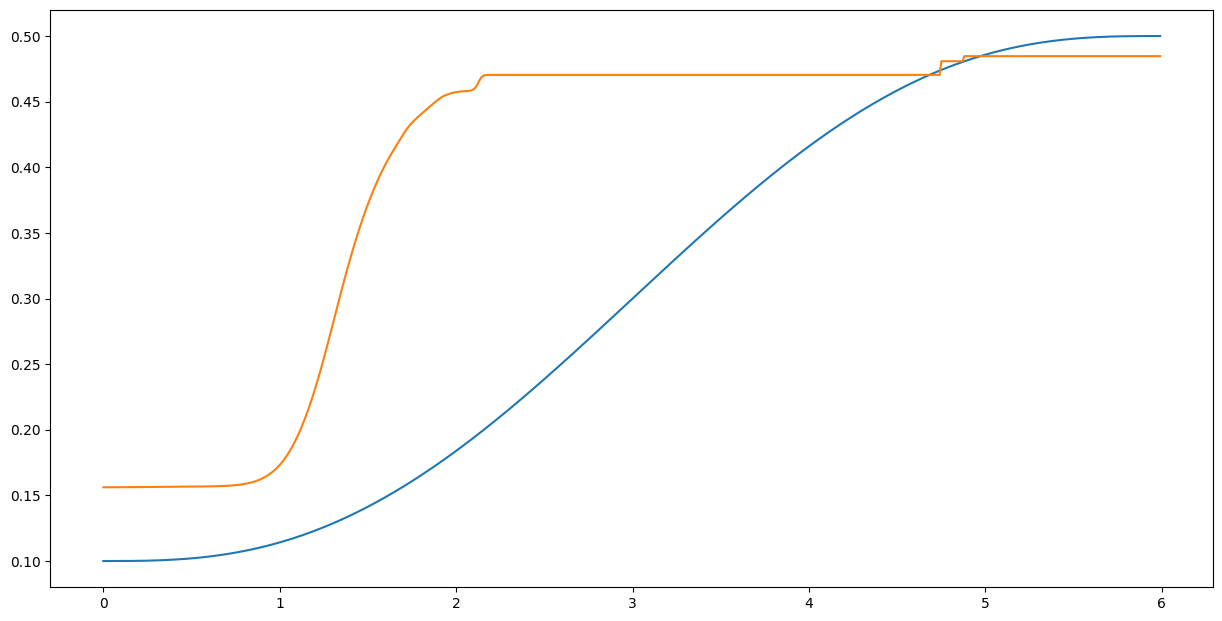

In [27]:
plt.figure(figsize=(15,7.5))
plt.plot(t_val,w_val)
plt.plot(time,omega)

# plt.plot(t_val,dw_val)
# plt.plot(t_val,ddw_val)

In [28]:
first_derivative  = []
second_derivative  = []

for t in time:
    output_time0,grad_output_time0,grad_grad_output_time0 = net.gradients_wrt_time(t)
    first_derivative.append(grad_output_time0.item())
    second_derivative.append(grad_grad_output_time0.item())


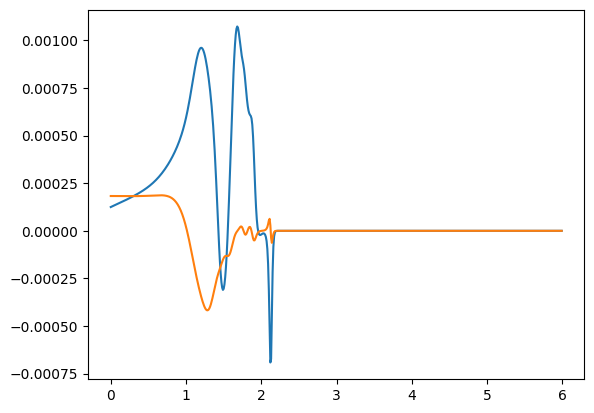

In [30]:
plt.plot(time , first_derivative)
plt.plot(time , second_derivative)


In [31]:
t_val = np.arange(0,6,0.01)
w_val_first = []
w_val_second = []
for t in t_val:
  w_val_first.append(polynomial_ansatz_first(t))
  w_val_second.append(polynomial_ansatz_second(t))

w_val_first = np.array(w_val_first)
w_val_second = np.array(w_val_second)


AttributeError: 'numpy.ndarray' object has no attribute 'append'